In [10]:
import itertools
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.tree._tree import TREE_LEAF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.stats import ttest_ind
from tqdm import tqdm

In [11]:
compas = pd.read_csv("compas-scores-two-years.csv")
compas

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


In [12]:
# copy the pre-processing steps from "Loading Data" found on: https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb
compas = compas[(compas["days_b_screening_arrest"] <= 30) & (compas["days_b_screening_arrest"] >= -30)]

# nr of rows match those in link
compas["sex"]

0         Male
1         Male
2         Male
5         Male
6         Male
         ...  
7209      Male
7210      Male
7211      Male
7212    Female
7213    Female
Name: sex, Length: 6172, dtype: object

In [13]:
# separate labels
compas_y = compas["two_year_recid"]
compas_X = compas.drop("two_year_recid", axis=1)

In [14]:
compas_y = compas_y.map({0:1, 1:0})

In [15]:
compas_X = compas_X[["age", "c_charge_degree", "age_cat", "score_text", "sex", "priors_count", 
                    "days_b_screening_arrest", "decile_score", "race", "in_custody", "out_custody"]]


In [16]:
# convert dates to just years and numerical types
def date_to_justyear(date):
    if type(date) == str:
        return int(date[:4])
    
    return date

for column in ["in_custody", "out_custody"]:
    compas_X[column] = compas_X[column].apply(func=date_to_justyear, convert_dtype=True)
    

In [17]:
# separate sensitive attributes
compas_sex = compas_X["sex"]
compas_race = compas_X["race"]
compas_age = compas_X["age"]
compas_age_cat = compas_X["age_cat"]
compas_X = compas_X.drop(["race", "sex", "age", "age_cat"], axis=1)

In [18]:
compas_race = compas_race.map({"Caucasian": "White", "African-American": "Non_White", "Hispanic": "Non_White", "Other": "Non_White", "Asian": "Non_White", "Native American": "Non_White"})

In [19]:
# impute the numerical missing values with the median
compas_X = compas_X.fillna(compas_X.median())

/var/folders/d6/97vsb8ys2xsd5zzsdl4ndt6c0000gn/T/ipykernel_6477/1967445180.py:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  compas_X = compas_X.fillna(compas_X.median())


In [20]:
# convert to one-hot-encoding
compas_cat_X = pd.get_dummies(compas_X, columns=["in_custody", "out_custody", "c_charge_degree", "score_text"])
compas_cat_X

,priors_count,days_b_screening_arrest,decile_score,in_custody_2003,in_custody_2009,in_custody_2013,in_custody_2014,in_custody_2015,in_custody_2016,out_custody_2013,out_custody_2014,out_custody_2015,out_custody_2016,out_custody_2020,c_charge_degree_F,c_charge_degree_M,score_text_High,score_text_Low,score_text_Medium
0,0,-1.0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0
1,0,-1.0,3,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0
2,4,-1.0,4,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0
5,0,0.0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0
6,14,-1.0,6,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,0,-1.0,7,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1
7210,0,-1.0,3,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0
7211,0,-1.0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0
7212,3,-1.0,2,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0


In [21]:
# make a train and test split with same proportional size as Adult dataset
compas_train_cat_X, compas_test_cat_X, compas_train_y, compas_test_y= train_test_split(compas_cat_X, compas_y, test_size=1/3, random_state=42)

# also for the sensitive attributes with same random_state
compas_train_sex, compas_test_sex, compas_train_y, compas_test_y = train_test_split(compas_sex, compas_y, test_size=1/3, random_state=42)
compas_train_race, compas_test_race, compas_train_y, compas_test_y = train_test_split(compas_race, compas_y, test_size=1/3, random_state=42)
compas_train_age, compas_test_age, compas_train_y, compas_test_y = train_test_split(compas_age, compas_y, test_size=1/3, random_state=42)

In [22]:
# construct decision tree
tree = DecisionTreeClassifier(random_state=42)

parameter_grid={"criterion":["entropy", "gini"], "max_depth":[2, 3, 4], 
                "max_features":["sqrt", None, "log2"], 
                "max_leaf_nodes":[3, 4, 5, 6, 7, 8, 9, 10, 11, 12], "ccp_alpha": [0, 0.01, 0.05, 0.1],
               "min_impurity_decrease": [0.005, 0.01, 0.025, 0.05]}
tree_cv = GridSearchCV(tree, param_grid=parameter_grid, scoring='balanced_accuracy', n_jobs=2, cv=3, verbose=1)
tree_cv.fit(compas_train_cat_X, compas_train_y)
best_tree = tree_cv.best_estimator_
best_tree

Fitting 3 folds for each of 2880 candidates, totalling 8640 fits


DecisionTreeClassifier(ccp_alpha=0, criterion='entropy', max_depth=4,
                       max_leaf_nodes=8, min_impurity_decrease=0.005,
                       random_state=42)

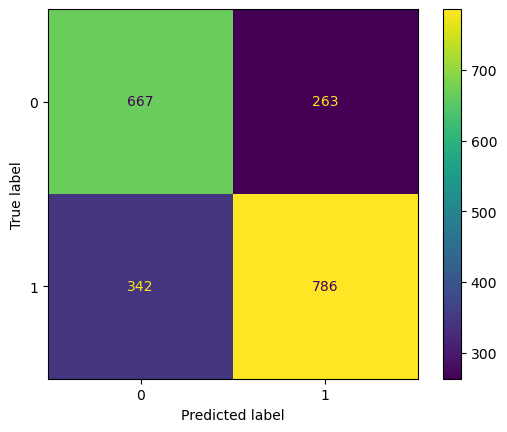

In [23]:
# confusion matrix / performance on testset
y_pred = best_tree.predict(compas_test_cat_X)
cm = confusion_matrix(compas_test_y, y_pred, labels=best_tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_tree.classes_)
disp.plot()

In [24]:
print(f"Balanced accuracy on test set: {balanced_accuracy_score(compas_test_y, y_pred)}")
print(f"ROC-AUC score on test set: {roc_auc_score(compas_test_y, y_pred)}")
print(f"Accuracy score: {accuracy_score(compas_test_y, y_pred)}")

Balanced accuracy on test set: 0.7070064058567833
ROC-AUC score on test set: 0.7070064058567833
Accuracy score: 0.706025267249757


In [25]:
column_names = [name for name in compas_train_cat_X.columns]
print(export_text(best_tree, feature_names=column_names))

|--- out_custody_2013 <= 0.50
|   |--- decile_score <= 4.50
|   |   |--- out_custody_2014 <= 0.50
|   |   |   |--- class: 0
|   |   |--- out_custody_2014 >  0.50
|   |   |   |--- priors_count <= 1.50
|   |   |   |   |--- class: 1
|   |   |   |--- priors_count >  1.50
|   |   |   |   |--- class: 0
|   |--- decile_score >  4.50
|   |   |--- class: 0
|--- out_custody_2013 >  0.50
|   |--- priors_count <= 1.50
|   |   |--- decile_score <= 3.50
|   |   |   |--- class: 1
|   |   |--- decile_score >  3.50
|   |   |   |--- class: 1
|   |--- priors_count >  1.50
|   |   |--- decile_score <= 5.50
|   |   |   |--- class: 1
|   |   |--- decile_score >  5.50
|   |   |   |--- class: 0



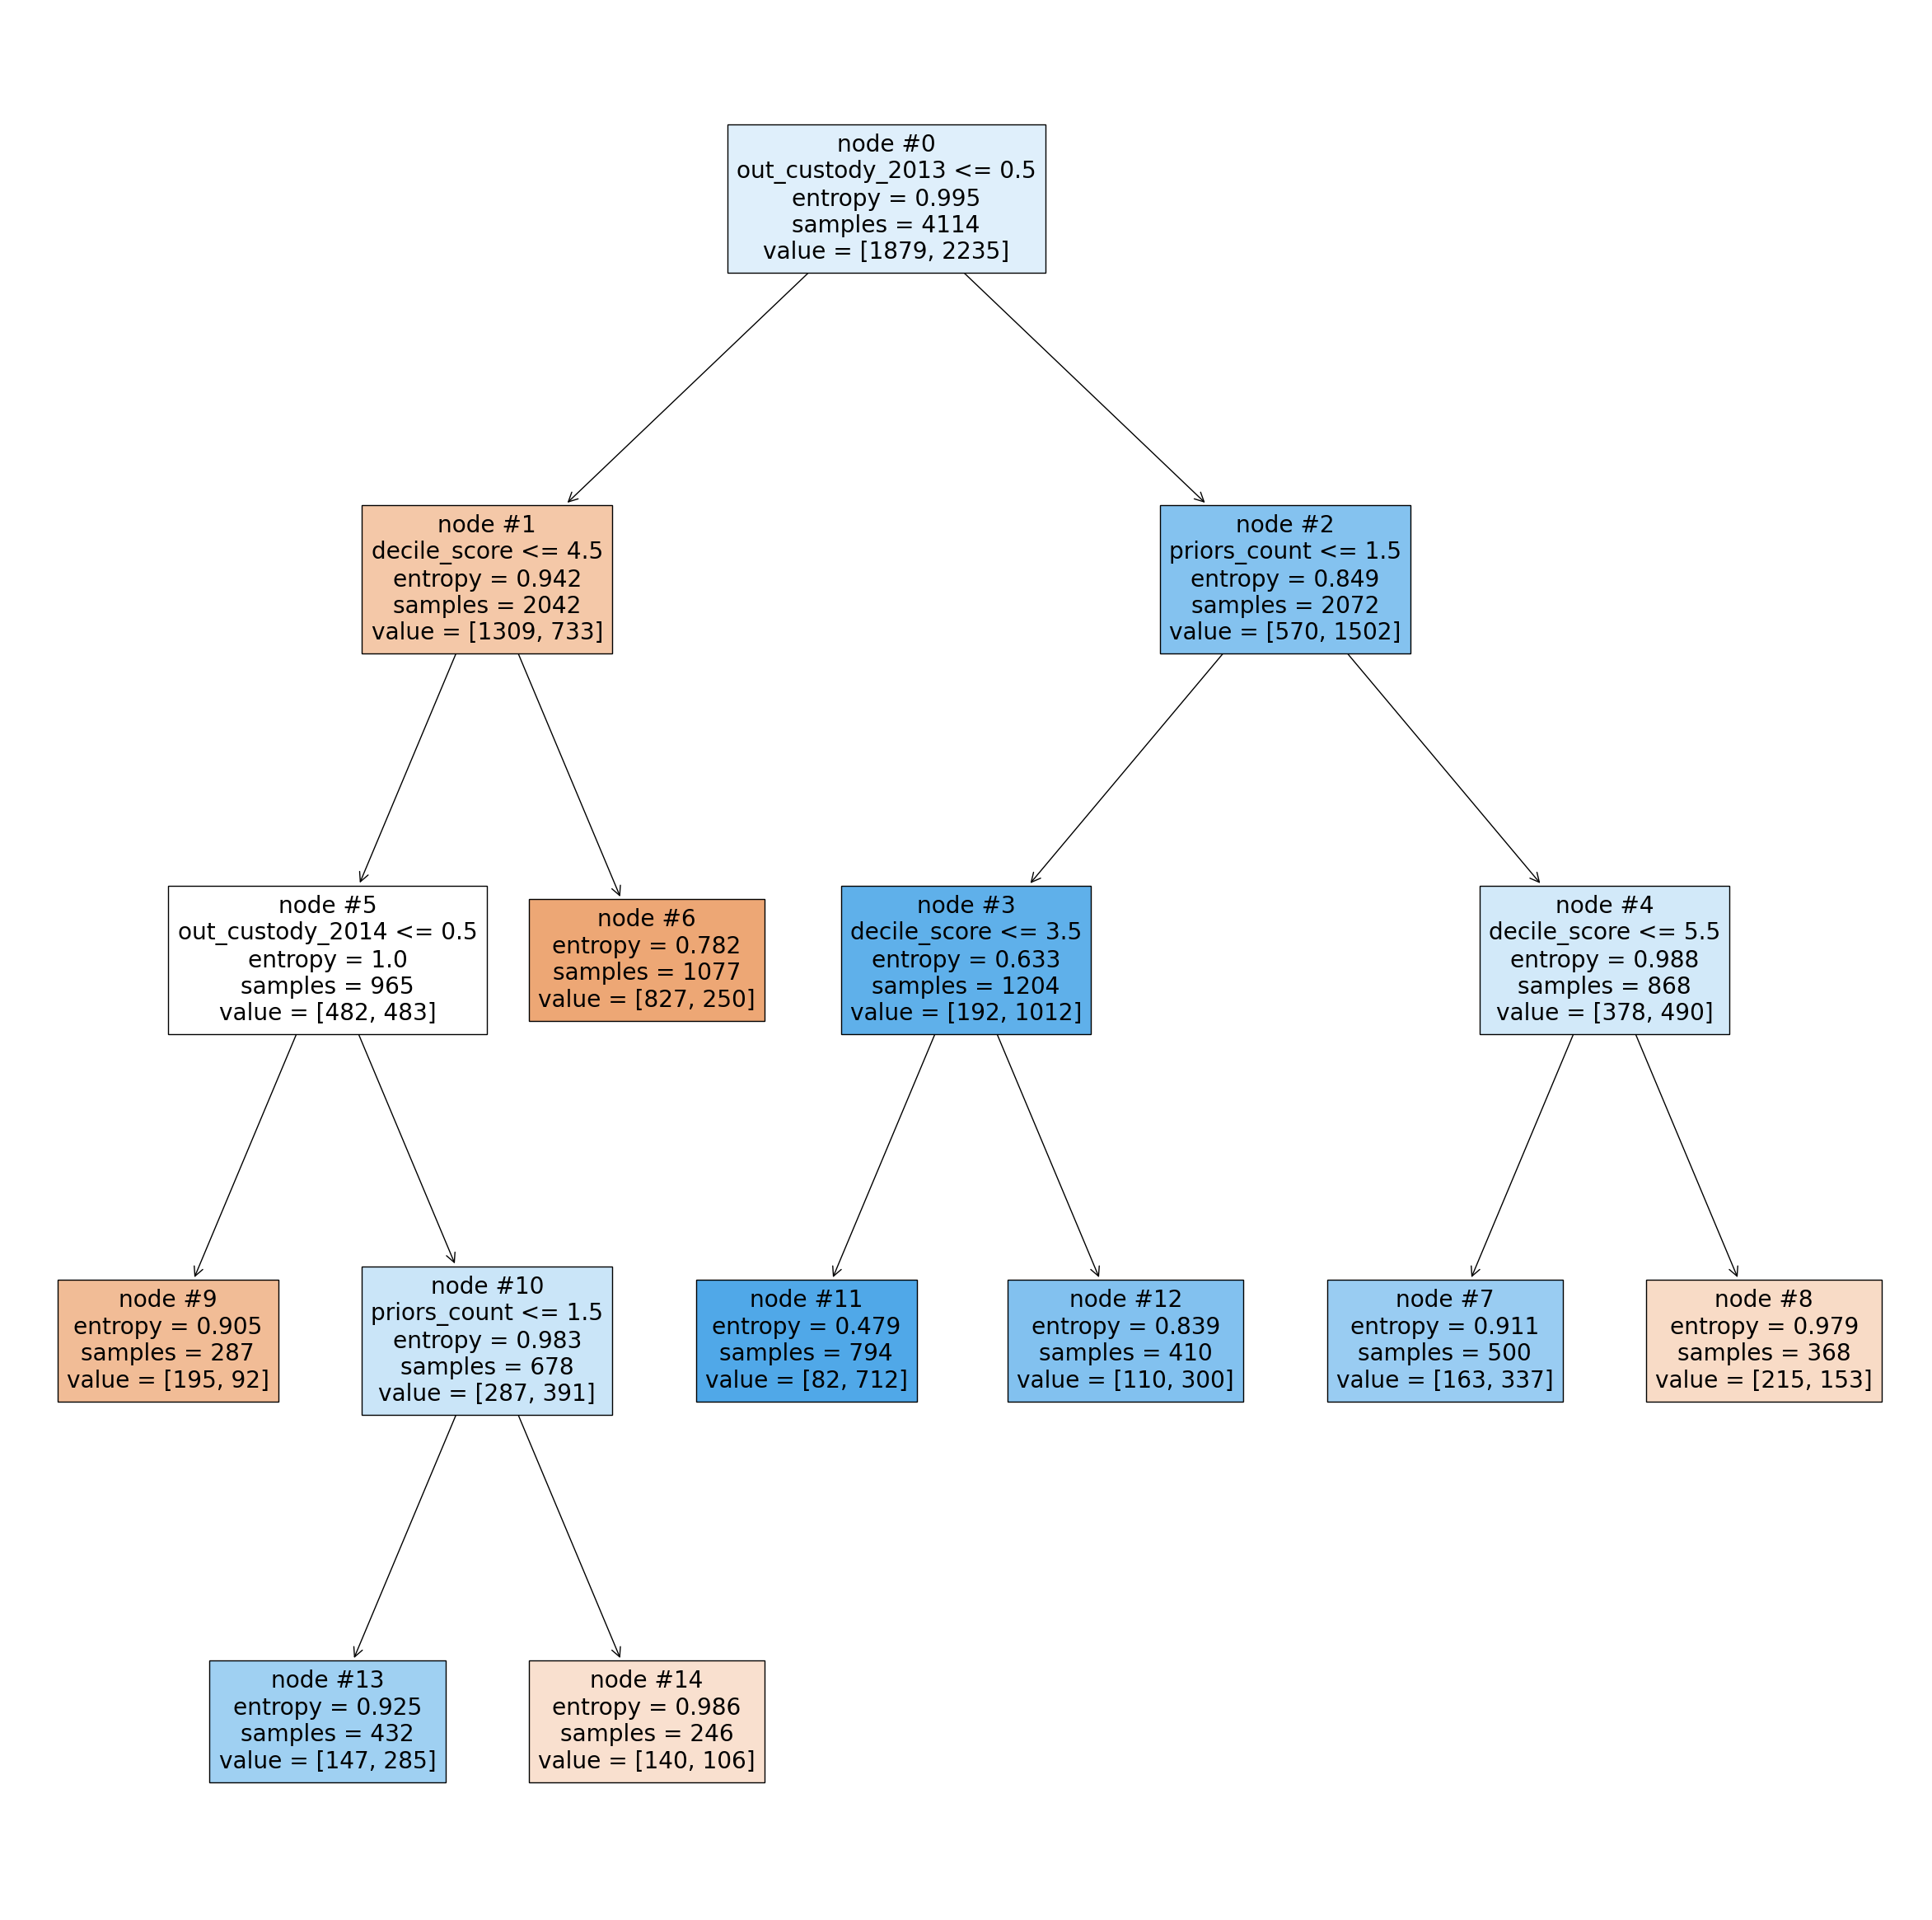

In [26]:
plt.figure(figsize=(30,30))
plot_tree(best_tree, feature_names=compas_train_cat_X.columns, filled=True, node_ids=True)
# plt.savefig("compastree", dpi=800)
plt.show()

In [27]:
# taken from: https://stackoverflow.com/a/51398390
def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and 
            inner_tree.children_right[index] == TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:     
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        ##print("Pruned {}".format(index))

def prune_duplicate_leaves(mdl):
    # Remove leaves if both 
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    prune_index(mdl.tree_, decisions)
    
# pruning happens in-place
prune_duplicate_leaves(best_tree)

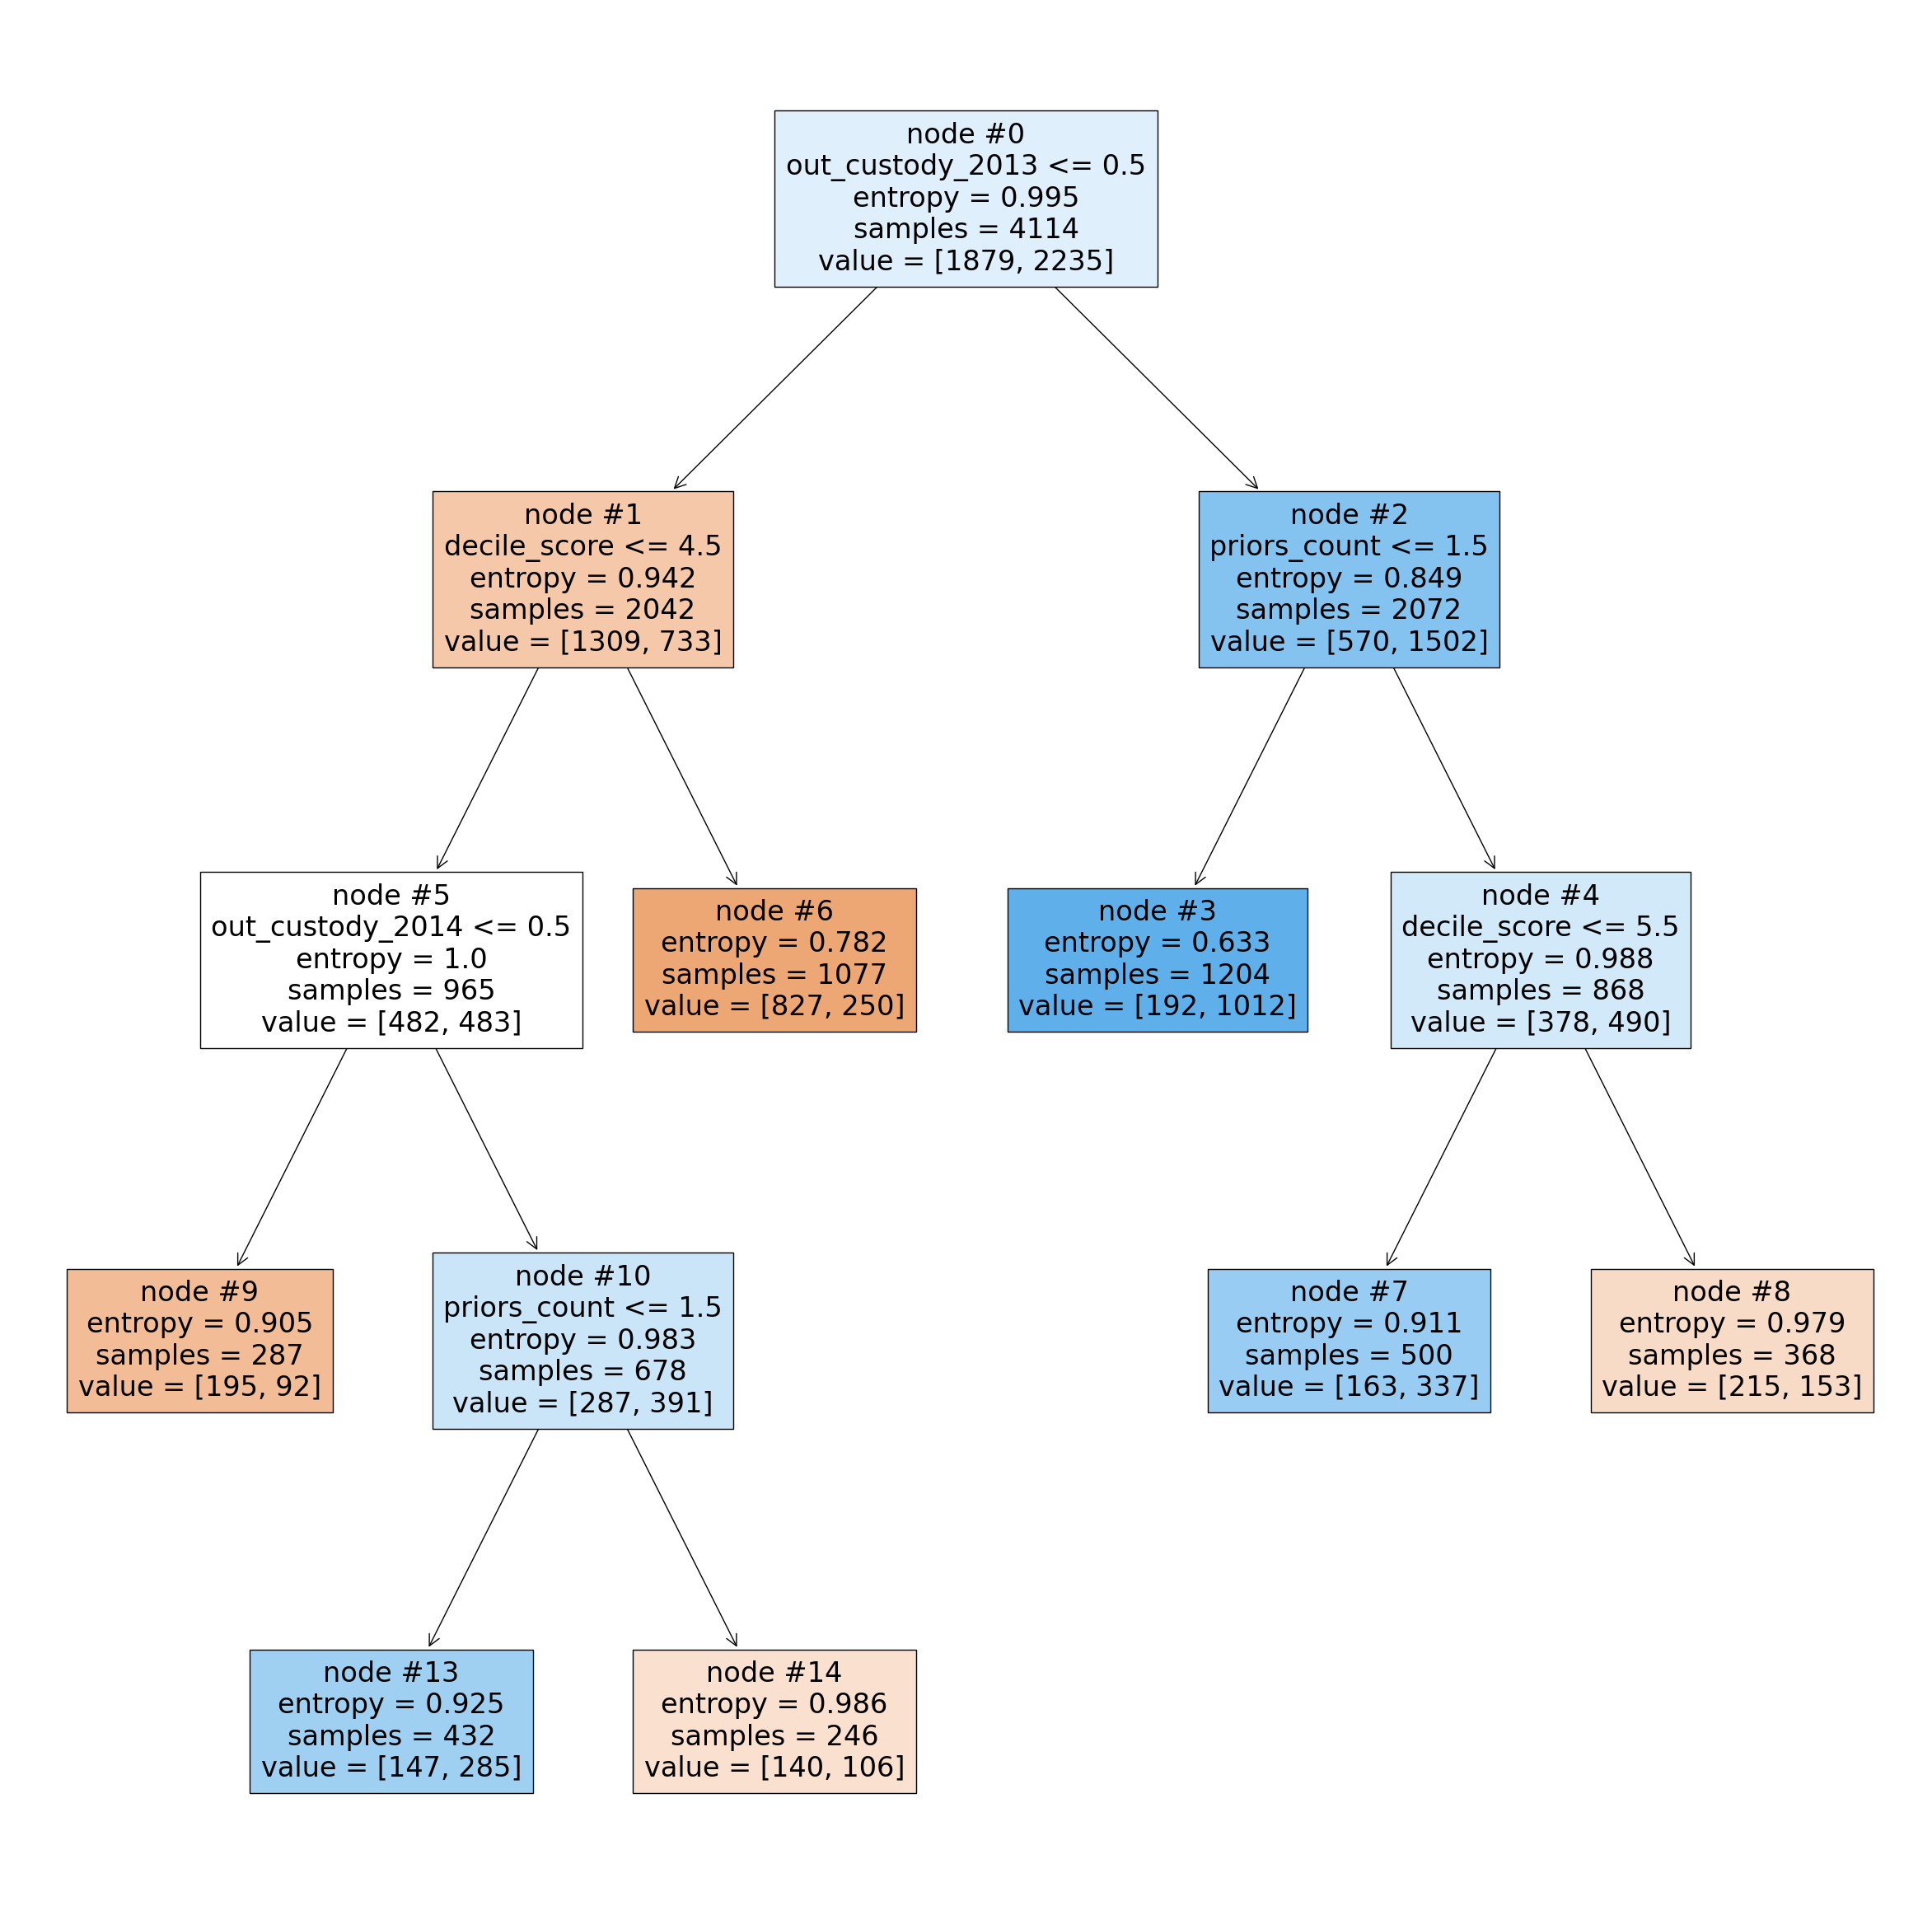

In [28]:
plt.figure(figsize=(30,30))
plot_tree(best_tree, feature_names=compas_train_cat_X.columns, filled=True, node_ids=True)
plt.savefig("compastree", dpi=800)
plt.show()

In [29]:
# taken from: https://stackoverflow.com/a/56427596
n_nodes = best_tree.tree_.node_count
children_left = best_tree.tree_.children_left
children_right = best_tree.tree_.children_right
feature = best_tree.tree_.feature
threshold = best_tree.tree_.threshold

def find_path(node_numb, path, x):
    path.append(node_numb)
    if node_numb == x:
        return True
    left = False
    right = False
    if (children_left[node_numb] !=-1):
        left = find_path(children_left[node_numb], path, x)
    if (children_right[node_numb] !=-1):
        right = find_path(children_right[node_numb], path, x)
    if left or right:
        return True
    path.remove(node_numb)
    return False


def get_rule(df_name, path, column_names):
    mask = '('
    for index, node in enumerate(path):
        # check if we are not in the leaf
        if index!=len(path)-1:
            # under or over the threshold?
            if (children_left[node] == path[index+1]):
                mask += f"{df_name}['{column_names[feature[node]]}']<= {threshold[node]}\t "
            else:
                mask += f"{df_name}['{column_names[feature[node]]}']> {threshold[node]} \t "
                
    # insert the & at the right places
    mask = mask.replace("\t", "&", mask.count("\t") - 1)
    mask = mask.replace("\t", "")
    mask += ")"
    return mask


In [30]:
# Leaves
leave_id = best_tree.apply(compas_test_cat_X)

paths = {}
for leaf in np.unique(leave_id):
    path_leaf = []
    find_path(0, path_leaf, leaf)
    paths[leaf] = np.unique(np.sort(path_leaf))

rules = {}
for key in paths:
    rules[key] = get_rule("compas_test_cat_X", paths[key], column_names)

rules

{3: "(compas_test_cat_X['out_custody_2013']> 0.5 & compas_test_cat_X['priors_count']<= 1.5 )",
 6: "(compas_test_cat_X['out_custody_2013']<= 0.5& compas_test_cat_X['decile_score']> 4.5  )",
 7: "(compas_test_cat_X['out_custody_2013']> 0.5 & compas_test_cat_X['priors_count']> 1.5 & compas_test_cat_X['decile_score']<= 5.5 )",
 8: "(compas_test_cat_X['out_custody_2013']> 0.5 & compas_test_cat_X['priors_count']> 1.5 & compas_test_cat_X['decile_score']> 5.5  )",
 9: "(compas_test_cat_X['out_custody_2013']<= 0.5& compas_test_cat_X['decile_score']<= 4.5& compas_test_cat_X['out_custody_2014']<= 0.5 )",
 13: "(compas_test_cat_X['out_custody_2013']<= 0.5& compas_test_cat_X['decile_score']<= 4.5& compas_test_cat_X['out_custody_2014']> 0.5 & compas_test_cat_X['priors_count']<= 1.5 )",
 14: "(compas_test_cat_X['out_custody_2013']<= 0.5& compas_test_cat_X['decile_score']<= 4.5& compas_test_cat_X['out_custody_2014']> 0.5 & compas_test_cat_X['priors_count']> 1.5  )"}

In [31]:
def positive_rules(tree, rules):
    """From the extracted rules, return those that have a favorable classification
    
    Arg:
        tree: The tree classification object from which the rules are extracted.
        rules: Dict of which the values are rule strings.
        
    Returns:
        A list of all the rules that classify favorably"""
    
    # only those rules are added for which the majority of individuals in the node is at index 1
    # index 1 corresponds to class 1
    return [rule for node_id, rule in rules.items() if np.argmax(tree.tree_.value[node_id][0])]

positive_rules(best_tree, rules)

["(compas_test_cat_X['out_custody_2013']> 0.5 & compas_test_cat_X['priors_count']<= 1.5 )",
 "(compas_test_cat_X['out_custody_2013']> 0.5 & compas_test_cat_X['priors_count']> 1.5 & compas_test_cat_X['decile_score']<= 5.5 )",
 "(compas_test_cat_X['out_custody_2013']<= 0.5& compas_test_cat_X['decile_score']<= 4.5& compas_test_cat_X['out_custody_2014']> 0.5 & compas_test_cat_X['priors_count']<= 1.5 )"]

In [32]:
def oracle(dataset, sens_dataset, rule, s_i, mechanism=None, epsilon=0.05, delta=0.001):
    """Returns some (differentially privatised) statistics on the sensitive attribute for the specified dataframe and rule
    
    Args:
        df: The DataFrame that the developers own, which does not contain sensitive attributes.
            Used to calculate total quantities in (root) nodes.
        sens_dataset: A Series that the developers do not own, which contains the sensitive attributes. 
            Combined sensitive attributes should be encoded as a Series, e.g. Black-Female
        rule: The rule, as a string, for which the to estimate the sensitive attribute.
        s_i: The sensitive attribute, its name comes from the ith element in the set S of sensitive attributes.
            s_i should be in sens_dataset and should thus be a string. 
        mechanism: The privacy mechanism used on the returned counts. Can be one of "gaussian", "laplacian", "exponential", None. 
        epsilon: The privacy budget. Should be larger than 0.
        delta: The privacy margin. Ignored when mechanism is either laplacian or gaussian. Should be in (0, 1]. 
        
    Returns:
        The number of times s_i occurs in sens_dataset, privatised via the mechanism. 
        """
        
    # check epsilon and delta parameters
    if epsilon <= 0 or (mechanism == "gaussian" and (delta <= 0 or delta > 1 or epsilon > 1)):
        raise ValueError("The value of delta should be in (0,1] when using the gaussian mechanism")
    
    if not sens_dataset.isin([s_i]).any():
        raise KeyError("The requested sensitive attribute (s_i) is not in the sensitive dataframe (sens_dataset)")
    
    # the answer if no privacy mechanism is applied    
    try:
        no_mechanism = sens_dataset.loc[dataset[pd.eval(rule, engine='python')].index].value_counts(sort=False)[s_i]
        
    except KeyError:
        no_mechanism = 0
    
    if mechanism == "laplacian":
        # this is a histogram query so the l1-sensitivity = 1 as per Dwork & Roth 
        sensitivity = 1
        return no_mechanism + np.random.laplace(loc=0, scale=sensitivity / epsilon)
    
    elif mechanism == "gaussian":
        # this is a histogram query so the l2-sensitivity = 2 as per Dwork & Roth
        sensitivity = 2
        return no_mechanism + np.random.normal(loc=0, scale=2 * sensitivity**2 * np.log(1.25 / delta) / epsilon**2)
    
    elif mechanism == "exponential":
        # this query can only change by 1 if an instance is omitted so l1-sensitivity = 1
        sensitivity = 1
        
        # np.arange is [start, stop) so + 1 for entire possible range
        possible_values = np.arange(0, sens_dataset.loc[dataset[pd.eval(rule, engine='python')].index].value_counts().to_numpy().sum() + 1)
        
        # the utility is higher when the value is closer to the actual value
        utility_scores = np.array([no_mechanism - abs(no_mechanism - value) for value in possible_values]) / 100
        probabilities = [np.exp(epsilon * score / (2 * sensitivity)) for score in utility_scores]
        
        # normalize probabilties to sum to 1
        probabilities /= np.linalg.norm(probabilities, ord=1)
        return np.random.choice(possible_values, p=probabilities)

    # if no mechanism is given, return the unprivatised cocunt
    return no_mechanism

oracle(compas_test_cat_X, compas_test_sex, rules[3], "Male", "laplacian", epsilon=1, delta=0.1)

465.799739086629

In [39]:
def statistical_parity(y_pred, sens_dataset):
    """Calculates Statistical Parity Ratio using the predictions and the actual sensitive feature values
    
    Args:
        y_pred: The predictions, should be of same size as sens_dataset.
        sens_dataset: The Series with the sensitive attributes.
        
    Returns:
        The true statistical parity ratio.
        """
    accept_rates = []
    
    for sens_attr in sorted(sens_dataset.unique()):
        accept_rates.append(np.sum((sens_dataset == sens_attr) & y_pred) / np.sum(sens_dataset == sens_attr))
        
    return accept_rates[0] / accept_rates[1]


def estimate_sp(pos_ruleset, dataset, sens_dataset, S, mechanism, epsilon, delta, histogram=False):
    """Returns the estimated Statistical Parity of a tree for a privacy mechanism
    
    Args:
        pos_ruleset: A list of rules that classify favorably in the tree. This is the representation of the
        (relevant parts of the) tree. 
        dataset: The DataFrame that the developers own that does not contain sensitive feature values.
        sens_dataset: The Series that contains the sensitive features, which the developers do not own.
        S: The set/list of sensitive attributes, should all be in the sens_dataset attribute.
        mechanism: The mechanism with which to privatise the queries. 
        epsilon: The privacy budget for the privacy mechanism. Should be larger than 0.
        delta: The privacy margin. Ignored when mechanism is either laplacian or gaussian. Should be in (0, 1].
        
    Returns:
        The statistical parity ratio for the specified pos_ruleset. 
        """
    
    poscounts_per_si = np.zeros(len(S))
    
    # the variable name of the current dataset is inferred from the ruleset
    datasetname = str(pos_ruleset[0].split('[')[0])[1:]
    
    # the base rule is a rule that includes all individuals, i.e. the condition is a tautology
    # in this case we select all rows that have a value that is in the set of possible values of the first column
    base_rule = f"({datasetname}[{datasetname}.columns[0]].isin({datasetname}[{datasetname}.columns[0]].unique()))"
    
    if histogram:
        total_per_si = [oracle(dataset, sens_dataset, base_rule, s_i, mechanism, 0.5 * epsilon, delta) for s_i in S]
            
    else:
        # we can calculate the last count ourselves so we iterate one less
        total_per_si = [oracle(dataset, sens_dataset, base_rule, s_i, mechanism, 0.5 * epsilon, delta) for s_i in S[:-1]]
        total_per_si.append(len(sens_dataset) - sum(total_per_si))
        
    total_per_si = np.array(total_per_si)
    
    for rule in pos_ruleset:
        # for each rule we find the distribution of sensitive attributes
        rule_counts = np.zeros(len(S))
        rule_total = len(sens_dataset[pd.eval(rule)])
        
        if histogram:
            for i, s_i in enumerate(S):
                # because the queries are disjoint, epsilon remains equal across queries
                rule_counts[i] += round(oracle(dataset, sens_dataset, rule, s_i, mechanism, 0.5 * epsilon, delta))
        
        else:
        # we can calculate the last count ourselves so we iterate one less
            for i, s_i in enumerate(S[:-1]):
                # because the queries are disjoint, epsilon remains equal across queries
                rule_counts[i] += round(oracle(dataset, sens_dataset, rule, s_i, mechanism, 0.5 * epsilon, delta))
            
            rule_counts[-1] += rule_total - np.sum(rule_counts[:-1])
        
        # the distribution for the current rule is added to the total
        poscounts_per_si += rule_counts
    
    if not np.any(total_per_si[total_per_si != 0]):
        print(f"Totals for epsilon: {epsilon} has no correct values ({total_per_si})")
        
    if np.any(total_per_si < 0):
        print(f"Negative numbers in total_per_si: {total_per_si}")
    
    # replace the total count with the number of positives (total >= pos) if it is 0
    total_per_si = [pos if total == 0 else total for pos, total in zip(poscounts_per_si, total_per_si)]    
        
    # calculate and return sp
    return (poscounts_per_si[total_per_si != 0][0] / total_per_si[total_per_si != 0][0]) / (poscounts_per_si[total_per_si != 0][1] / total_per_si[total_per_si != 0][1])


In [35]:
def experiment(ruleset, tree, dataset, sens_dataset, epsilon, 
               delta=0.0001, mechanisms=["exponential", "gaussian", "laplacian"], runs=10, histogram=False, combined=False):
    """Compares average Statistical Parity Error for different mechanisms
    
    Args:
        ruleset: The rules that represent a rule based decision system.
        tree: The tree classification object that was used to construct the ruleset.
        dataset: The DataFrame that the developers own that does not contain sensitive feature values.
        sens_dataset: The Series that contains the sensitive features, which the developers do not own.
        epsilon: The privacy budget for the privacy mechanism. Should be larger than 0.
        delta: The privacy margin. Ignored when mechanism is either laplacian or gaussian. Should be in (0, 1].
        mechanisms: The list of mechanisms you want to compare. 
            Should be a subset of {"exponential", "gaussian", "laplacian", "None"}.
        runs: The number of times to perform the experiment, fewer runs will result in less reliable outcomes. 
        
    Returns:
        A numpy array that contains the absolute difference between the actual sp and the estimated sp. 
    """
    
    pos_rules = positive_rules(tree, ruleset)
    if combined:
        pos_rules = [" | ".join(rule for rule in pos_rules)]
        
    actual_sp = statistical_parity(tree.predict(dataset), sens_dataset)
    errors = np.zeros((runs, len(mechanisms)))
    S = sens_dataset.value_counts(sort=False).index
    
    for row in range(runs):
        for col, mechanism in enumerate(mechanisms):
            errors[row, col] = abs(estimate_sp(pos_rules, dataset, sens_dataset, S, mechanism, epsilon, delta, histogram=histogram) - actual_sp)
            
    return errors


In [38]:
print(statistical_parity(best_tree.predict(compas_test_cat_X), compas_test_sex))
print(statistical_parity(best_tree.predict(compas_train_cat_X), compas_train_sex))

print(compas_train_sex.value_counts())

experiment(rules, best_tree, compas_test_cat_X, compas_test_race, 
           epsilon=0.5, delta=0.0001, mechanisms=['laplacian'], runs=2, histogram=True)

1.1831595606032397
1.2020460358056266
Male      3332
Female     782
Name: sex, dtype: int64


array([[0.03369407],
       [0.00719687]])

In [116]:
epsilons = np.linspace(0.01, 0.5, 40)
runs = 50

laplace_errs_hist, exp_errs_hist = [], []
laplace_uncert_hist, exp_uncert_hist = [], []
for epsilon in tqdm(epsilons):
    sp_errs = experiment(rules, best_tree, compas_test_cat_X,
                         compas_test_sex, epsilon=epsilon, runs=runs, mechanisms=["laplacian", "exponential"], histogram=True)
    
    avg_errs = np.mean(sp_errs, axis=0)
    std_errs = np.std(sp_errs, ddof=1, axis=0)
    uncertainty = std_errs / np.sqrt(runs)
    
    laplace_errs_hist.append(avg_errs[0])
    exp_errs_hist.append(avg_errs[1])
    laplace_uncert_hist.append(uncertainty[0])
    exp_uncert_hist.append(uncertainty[1])
    

100%|███████████████████████████████████████████████████████████████████████████████| 40/40 [2:53:32<00:00, 260.30s/it]


In [117]:
laplace_errs_hist = np.array(laplace_errs_hist)
exp_errs_hist = np.array(exp_errs_hist)
laplace_uncert_hist = np.array(laplace_uncert_hist)
exp_uncert_hist = np.array(exp_uncert_hist)

for arr, name in zip([laplace_errs_hist, exp_errs_hist, laplace_uncert_hist, exp_uncert_hist], ["laplace_errs", "exp_errs", "laplace_uncert", "exp_uncert"]):
    with open(f"compas-sex-{name}", "wb") as f:
        np.save(f, arr)

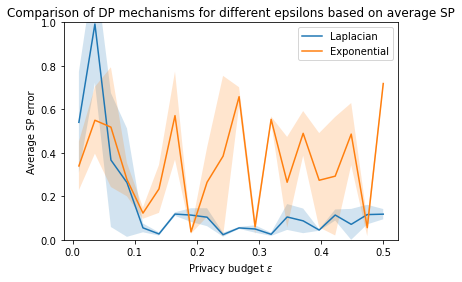

In [79]:
plt.plot(epsilons, laplace_errs_hist, label="Laplacian")
plt.fill_between(epsilons, laplace_errs_hist + laplace_uncert_hist, laplace_errs_hist - laplace_uncert_hist, alpha=0.2)
plt.plot(epsilons, exp_errs_hist, label="Exponential")
plt.fill_between(epsilons, exp_errs_hist + exp_uncert_hist, exp_errs_hist - exp_uncert_hist, alpha=0.2)
plt.legend()
plt.title("Comparison of DP mechanisms for different epsilons based on average SP")
plt.ylabel("Average SP error")
plt.xlabel("Privacy budget $\epsilon$")
plt.ylim([0, 1])
plt.savefig(fname=f"compas-sex-mechcomp-{datetime.now():%Y-%m-%d-%H_%M_%S}-{runs}.png", dpi=800)
plt.show()

In [23]:
epsilons = np.linspace(0.01, 0.5, 40)
runs = 50

laplace_errs_hist, exp_errs_hist = [], []
laplace_uncert_hist, exp_uncert_hist = [], []
for epsilon in tqdm(epsilons):
    sp_errs = experiment(rules, best_tree, compas_test_cat_X,
                         compas_test_race, epsilon=epsilon, runs=runs, mechanisms=["laplacian", "exponential"], histogram=True)
    
    avg_errs = np.mean(sp_errs, axis=0)
    std_errs = np.std(sp_errs, ddof=1, axis=0)
    uncertainty = std_errs / np.sqrt(runs)
    
    laplace_errs_hist.append(avg_errs[0])
    exp_errs_hist.append(avg_errs[1])
    laplace_uncert_hist.append(uncertainty[0])
    exp_uncert_hist.append(uncertainty[1])
    

  0%|                                                                 | 0/40 [00:00<?, ?it/s]

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=None, max_leaf_nodes=10; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=None, max_leaf_nodes=10; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=None, max_leaf_nodes=11; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=None, max_leaf_nodes=11; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=None, max_leaf_nodes=11; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=None, max_leaf_nodes=12; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=log2, max_leaf_nodes=7; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=log2, max_leaf_nodes=8; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=log2, max_leaf_nodes=8; total

100%|███████████████████████████████████████████████████| 40/40 [16:21:33<00:00, 1472.34s/it]


In [24]:
laplace_errs_hist = np.array(laplace_errs_hist)
exp_errs_hist = np.array(exp_errs_hist)
laplace_uncert_hist = np.array(laplace_uncert_hist)
exp_uncert_hist = np.array(exp_uncert_hist)

for arr, name in zip([laplace_errs_hist, exp_errs_hist, laplace_uncert_hist, exp_uncert_hist], ["laplace_errs", "exp_errs", "laplace_uncert", "exp_uncert"]):
    with open(f"compas-race-{name}", "wb") as f:
        np.save(f, arr)

In [1]:
laplace_errs_combined = np.array(laplace_errs_combined)
exp_errs_combined = np.array(exp_errs_combined)
laplace_uncert_combined = np.array(laplace_uncert_combined)
exp_uncert_combined = np.array(exp_uncert_combined)

plt.plot(epsilons, laplace_errs_combined, label="Laplacian")
plt.fill_between(epsilons, laplace_errs_combined + laplace_uncert_combined, laplace_errs_combined - laplace_uncert_combined, alpha=0.2)
plt.plot(epsilons, exp_errs_combined, label="Exponential")
plt.fill_between(epsilons, exp_errs_combined + exp_uncert_combined, exp_errs_combined - exp_uncert_combined, alpha=0.2)
plt.legend()
plt.title("Comparison of DP mechanisms for different epsilons based on average SP with combined query")
plt.ylabel("Average SP error")
plt.xlabel("Privacy budget $\epsilon$")
plt.savefig(fname=f"compas-sex-mechcomp-combined-{datetime.now():%Y-%m-%d-%H_%M_%S}-{runs}.png", dpi=800)
plt.show()

NameError: name 'np' is not defined

In [60]:
a = np.array([0, -1,3 ,4, 0])
b = np.array([1, 2, 0,4,0])
b[(a == 0) | (b == 0)]

array([1, 0, 0])

In [31]:
(a == 0) & (b == 0)

False

In [46]:
nonzero_dices = np.where((a > 0) & (b > 0))[0]
a[nonzero_dices]

array([2, 4])

In [45]:
nonzero_dices

array([0, 1, 2, 3], dtype=int64)

In [58]:
np.min(np.array([]))

ValueError: zero-size array to reduction operation minimum which has no identity

In [68]:
b[a != 0]

array([0, 4])